In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
# Load the Excel file
file_path = "Data_Analyst_Take_Home_Exercise_HF.xlsx"

# List all sheet names (optional)
xls = pd.ExcelFile(file_path)
print("Sheet names:", xls.sheet_names)

# Load a sheet into a DataFrame 
df = pd.read_excel(xls, sheet_name='Sheet1')
df = df.apply(lambda col: col.str.strip() if col.dtype == "object" else col)

Sheet names: ['Sheet1']


In [3]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (13536, 9)
Columns: ['Unique Id', 'Date', 'Site', 'Region', 'Case State', 'CTQ', 'Disease Burden', 'Returned Reason', 'IQ Score']


In [4]:
desc_stats = df.describe(include='all')
display(desc_stats) 

,Unique Id,Date,Site,Region,Case State,CTQ,Disease Burden,Returned Reason,IQ Score
count,13483,13536,13536,13082,13536,12274,12257,1226,13536.000000
unique,13483,NaN,1028,66,2,6,6,33,NaN
top,0006f2f08ab2,NaN,CEDARSC,US East,COMPLETED,ok,low,Motion,NaN
freq,1,NaN,223,3845,12290,8040,6322,443,NaN
mean,NaN,2024-11-05 02:24:59.999999744,NaN,NaN,NaN,NaN,NaN,NaN,0.538458
min,NaN,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-20.464475
25%,NaN,2024-11-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.435828
50%,NaN,2024-11-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.542605
75%,NaN,2024-11-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.638242
max,NaN,2024-11-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10.473252


# Missing data

In [5]:
missing_percent = df.isnull().mean() * 100 
print("Missing data percentage per column:\n" )
display(missing_percent.round(2).to_frame(name='% Missing'))

Missing data percentage per column:



,% Missing
Unique Id,0.39
Date,0.00
Site,0.00
Region,3.35
Case State,0.00
CTQ,9.32
Disease Burden,9.45
Returned Reason,90.94
IQ Score,0.00


In [6]:
missing_percent = df[df['Case State'] == 'COMPLETED'].isnull().mean() * 100
print("Missing data percentage per column - completed cases:\n" )
display(missing_percent.round(2).to_frame(name='% Missing (completed cases)'))

Missing data percentage per column - completed cases:



,% Missing (completed cases)
Unique Id,0.36
Date,0.00
Site,0.00
Region,3.35
Case State,0.00
CTQ,0.13
Disease Burden,0.27
Returned Reason,99.63
IQ Score,0.00


In [7]:
missing_percent = df[df['Case State'] != 'COMPLETED'].isnull().mean() * 100
print("Missing data percentage per column - returned cases:\n" )

display(missing_percent.round(2).to_frame(name='% Missing (returned cases)'))

Missing data percentage per column - returned cases:



,% Missing (returned cases)
Unique Id,0.72
Date,0.00
Site,0.00
Region,3.37
Case State,0.00
CTQ,100.00
Disease Burden,100.00
Returned Reason,5.30
IQ Score,0.00


# Data Quality - return reasons (handling data inconsistencies, grouping)

In [8]:
print(df['Returned Reason'].value_counts().sort_index())

Returned Reason
*                               50
A-Anatomy                        2
Bypass                          83
Bypass,m-stents                  2
C-Coronaries                    23
C-Coronaries,s-Misalignment      1
C-Myocardium                    27
GLC                             10
IM-hardware, M-Stents            1
Im-Hardware                     10
Im-Hardware,motion               1
Im-hardware, Motion              2
M-Stents                       160
M-Stents, motion                 1
M-Stents,motiOn                  1
Misalignment                     9
Misalignment/S-misalignment      8
Motion                         443
Motion/S-misalignment            1
NCP                              5
Noise                          150
Other...                        20
S-Misalignment                 195
S-Misalignmentt                  1
Unsupported RA                   3
misalignment,noise               1
misalignment/motion              4
mootion                          1
moti

- there are misspelled words, combined reasons
- Consolidate returned reasons into groups: Motion, Noise, S-Misalignment, G Low Contrast, A-Anatomy, Bypass, M-Stents, C-Myocardium, C-Coronaries, IM-Hardware, Unsupported RA, GLC, Misalignment, NCP and Other.


In [9]:
# Step 1: Normalize the text
df['Returned Reason2'] = df['Returned Reason'].str.lower().str.strip()

# Step 2: Extract the first reason (before comma or slash or ... )
df['Returned Reason2'] = df['Returned Reason2'].str.split(r'[,/]|\.{3,}').str[0].str.strip()

# # Step 3:  categories mapping
pattern_map = {
    r'\bm[o0]{1,2}tion\b': 'Motion',
    r'\bnoise\b': 'Noise',
    r'\bs?-?misalignmentt?\b': 'Misalignment',
    r'\bglc\b|\bg low contrast\b': 'G Low Contrast',
    r'\ba-?anatomy\b': 'A-Anatomy',
    r'\bbypass\b': 'Bypass',
    r'\bm-?stents\b': 'M-Stents',
    r'\bc-?myocardium\b': 'C-Myocardium',
    r'\bc-?coronaries\b': 'C-Coronaries',
    r'\bim-?hardware\b': 'IM-Hardware',
    r'\bunsupported ra\b': 'Unsupported RA',
    r'\bncp\b': 'NCP',
    r'\bother\b': 'Other'
}
def classify_reason(reason):
    for pattern, label in pattern_map.items():
        if re.search(pattern, reason):
            return label
    return 'N/A'  # fallback if no match

# Step 4: Apply the mapping
df['Returned Reason2'] = df['Returned Reason2'].astype(str).apply(classify_reason)
df[['Returned Reason', 'Returned Reason2']].drop_duplicates().sort_values(by=['Returned Reason', 'Returned Reason2'])

,Returned Reason,Returned Reason2
9,*,N/A
7758,A-Anatomy,A-Anatomy
103,Bypass,Bypass
1510,"Bypass,m-stents",Bypass
433,C-Coronaries,C-Coronaries
5808,"C-Coronaries,s-Misalignment",C-Coronaries
418,C-Myocardium,C-Myocardium
922,GLC,G Low Contrast
5649,"IM-hardware, M-Stents",IM-Hardware
1009,Im-Hardware,IM-Hardware


In [10]:
# grouping
# Step 1: Normalize the text
df['Returned Reason Group'] = df['Returned Reason2'].str.lower().str.strip()

# Step 2: Extract the first reason (before comma or slash or ... )
# df['Returned Reason2'] = df['Returned Reason2'].str.split(r'[,/]|\.{3,}').str[0].str.strip()

# # Step 3:  categories mapping
pattern_map = {
     r'\bm[o0]{1,2}tion\b': 'Human-Prone Error',
    r'\ba-?anatomy\b': 'Human-Prone Error',
    r'\bs?-?misalignmentt?\b': 'Human-Prone Error',
    
    # System or technical limitations
    r'\bnoise\b': 'Technical Limitation',
    r'\bglc\b|\bg low contrast\b': 'Technical Limitation',
    r'\bim-?hardware\b': 'Technical Limitation',
    r'\bunsupported ra\b': 'Technical Limitation',
    r'\bc-?myocardium\b': 'Technical Limitation',
    r'\bc-?coronaries\b': 'Technical Limitation',
    
    # Patient-specific factors
    r'\bbypass\b': 'Clinical Challenges',
    r'\bm-?stents\b': 'Clinical Challenges',
    r'\bncp\b': 'Clinical Challenges',
    
    # Fallback
    r'\bother\b': 'Other'
}
 

# Step 4: Apply the mapping
df['Returned Reason Group'] = df['Returned Reason Group'].astype(str).apply(classify_reason)


df[['Returned Reason2', 'Returned Reason Group']].drop_duplicates().sort_values(by=['Returned Reason2', 'Returned Reason Group'])

,Returned Reason2,Returned Reason Group
7758,A-Anatomy,Human-Prone Error
103,Bypass,Clinical Challenges
433,C-Coronaries,Technical Limitation
418,C-Myocardium,Technical Limitation
922,G Low Contrast,Technical Limitation
1009,IM-Hardware,Technical Limitation
5,M-Stents,Clinical Challenges
126,Misalignment,Human-Prone Error
16,Motion,Human-Prone Error
0,N/A,N/A


# Data Quality - Disease Burden (handling data inconsistencies, grouping & encoding)

In [11]:
print(df['Disease Burden'].value_counts().sort_index())

Disease Burden
ModeraTe       11
high         1885
high/High      20
low          6322
mOderate        8
moderate     4011
Name: count, dtype: int64


In [12]:
# Step 1: Normalize the text
df['Disease Burden2'] = df['Disease Burden'].str.lower().str.strip()

# Step 2: Extract the first reason (before comma or slash or ... )
df['Disease Burden2'] = df['Disease Burden2'].str.split(r'[,/]|\.{3,}').str[0].str.strip()

# # Step 3:  categories mapping
pattern_map = {
    r'\blow\b': 'Low',
    r'\bmoderate\b': 'Moderate',
    r'\bhigh\b': 'High'
}
 

# Step 4: Apply the mapping
df['Disease Burden2'] = df['Disease Burden2'].astype(str).apply(classify_reason)
df[['Disease Burden', 'Disease Burden2']].drop_duplicates().sort_values(by=['Disease Burden', 'Disease Burden2'])

,Disease Burden,Disease Burden2
2560,ModeraTe,Moderate
3,high,High
1961,high/High,High
0,low,Low
3024,mOderate,Moderate
6,moderate,Moderate
9,NaN,N/A


In [13]:
# Step 1: Normalize the text
df['Disease_Burden_encoded'] = df['Disease Burden'].str.lower().str.strip()

# Step 2: Extract the first reason (before comma or slash or ... )

# # Step 3:  categories mapping
pattern_map = {
    r'\blow\b': 1,
    r'\bmoderate\b': 2,
    r'\bhigh\b': 3
}
def classify_reason_num(reason):
    for pattern, label in pattern_map.items():
        if re.search(pattern, reason):
            return label
    return 0  # fallback if no match 

# Step 4: Apply the mapping
df['Disease_Burden_encoded'] = df['Disease_Burden_encoded'].astype(str).apply(classify_reason_num)
df[['Disease Burden2', 'Disease_Burden_encoded']].drop_duplicates().sort_values(by=['Disease Burden2', 'Disease_Burden_encoded'])

,Disease Burden2,Disease_Burden_encoded
3,High,3
0,Low,1
6,Moderate,2
9,N/A,0


# Data Quality - CTQ (handling data inconsistencies, grouping & encoding)

In [14]:
print(df['CTQ'].value_counts().sort_index())

CTQ
Okay            13
borderline    1628
excellent     2562
ok            8040
ok,Okay         20
okay            11
Name: count, dtype: int64


In [15]:
# Step 1: Normalize the text
df['CTQ2'] = df['CTQ'].str.lower().str.strip()

# Step 2: Extract the first reason (before comma or slash or ... )
df['CTQ2'] = df['CTQ2'].str.split(r'[,/]|\.{3,}').str[0].str.strip()

# # Step 3:  categories mapping
pattern_map = {
    r'\bborderline\b': 'Borderline',
    r'\bexcellent\b': 'Excellent',
    r'\bok(?:ay)?\b': 'OK',
    r'\bokay\b': 'OK'
}
 

# Step 4: Apply the mapping
df['CTQ2'] = df['CTQ2'].astype(str).apply(classify_reason)
df[['CTQ', 'CTQ2']].drop_duplicates().sort_values(by=['CTQ', 'CTQ2'])

,CTQ,CTQ2
295,Okay,OK
3,borderline,Borderline
0,excellent,Excellent
1,ok,OK
316,"ok,Okay",OK
2052,okay,OK
9,NaN,N/A


In [16]:
# Step 1: Normalize the text
df['CTQ2_encoded'] = df['CTQ'].str.lower().str.strip()

# Step 2: Extract the first reason (before comma or slash or ... )

# # Step 3:  categories mapping
pattern_map = {
    r'\bborderline\b': 1,
    r'\bexcellent\b': 3,
    r'\bok(?:ay)?\b': 2,
    r'\bokay\b':2
}
 

# Step 4: Apply the mapping
df['CTQ2_encoded'] = df['CTQ2_encoded'].astype(str).apply(classify_reason_num)
df[['CTQ2', 'CTQ2_encoded']].drop_duplicates().sort_values(by=['CTQ2', 'CTQ2_encoded'])

,CTQ2,CTQ2_encoded
3,Borderline,1
0,Excellent,3
9,N/A,0
1,OK,2


# Outliers

## date

In [17]:
# Find the minimum date
 
print(f"The minimum date is: {df['Date'].min()}")
print(f"The maximum date is: {df['Date'].max()}")

The minimum date is: 2021-11-01 00:00:00
The maximum date is: 2024-11-15 00:00:00


## IQ score

In [18]:
outliers = df[(df['IQ Score'] < 0) | (df['IQ Score'] > 1)]
print(f"IQ score number of outlier rows: {outliers.shape[0]}, {outliers.shape[0]/df.shape[0]:.4f}% total")  # Display count of outliers
print(outliers[['Unique Id', 'IQ Score']])  #  outlier rows


IQ score number of outlier rows: 42, 0.0031% total
          Unique Id   IQ Score
246    047fc5f82480   5.786599
406    078f1c49560c   4.467537
420    07d8616193f2   5.688687
519    099fc27b3243  -1.000000
562    0a6dba354719  -2.963543
914    11ba303e0239  -1.000000
1540   1d50a64f53e9  -2.963543
1974   25b86cf5a097   9.363637
2433   2e65ee13190a  -1.000000
2705   33d91c799eb1  -1.000000
3062   39ae2c73a264  -1.000000
3127   3af5319eff96  -1.000000
4029   4bde4b1fc659  -9.215256
4779   5a00497a69a8   4.675864
4793   5a3d12cecaee   9.636364
4815   5a9ff0f5e9e1   3.868462
4927   5c876636d3b3   9.533664
5359   64ca29c5a63c   4.757980
6002   70af041cceaf  -6.387946
6065   71ce6f8ba49a   9.363637
6609   7c0a0e8d3bca   8.242472
7235   8825662d88e3   9.533664
7253   887ec62768f7   5.786599
7312   899c3a4c35e1   8.242472
7791   92fefa3a49bf   5.688687
7856   9420df864d27  -6.387946
8008   9738d464a75a  -1.000000
8142   99d72ad7bafa   1.278655
8550   a1cfd60f9546   8.329673
8660   a3e934c9d6e8

# Mean and Median

In [19]:
# Mean and Average (they are the same for numeric data)
mean_iq = df['IQ Score'].mean()

# Median
median_iq = df['IQ Score'].median()

# Display the results
print(f"Mean of IQ Score: {mean_iq}")
print(f"Median of IQ Score: {median_iq}")

Mean of IQ Score: 0.5384575988962765
Median of IQ Score: 0.5426048715


# IQ score distributions

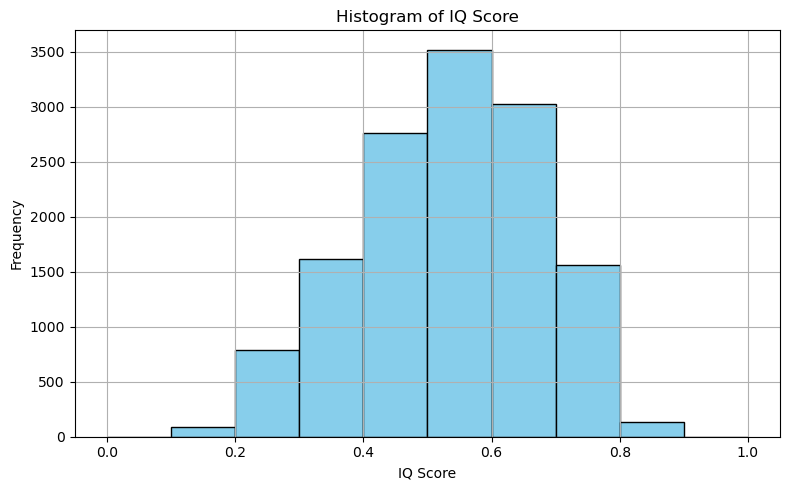

In [23]:
 
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df['IQ Score'], bins=10, range=(0, 1), color='skyblue', edgecolor='black')
plt.title('Histogram of IQ Score')
plt.xlabel('IQ Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

- IQ Score lightly left skewed
- replace outliers with the median

In [24]:
# replace outliers with the median
iq_score_median = df[(df['IQ Score'] >= 0) & (df['IQ Score'] <= 1)]['IQ Score'].median()
df['IQ Score cleaned'] = df['IQ Score'].apply(lambda x: iq_score_median if x < 0 or x > 1 else x)

# Export Clean Data

In [ ]:
df.to_excel('cleaned_data.xlsx', index=False)